In [1]:
import pathlib
import os
from PIL import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

import cv2

import random

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
batch_size = 1

In [4]:
# load the images and masks
dir_images_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/images')
dir_masks_train = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/train/masks')
dir_images_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/images')
dir_masks_test = pathlib.Path('../../data/kvasir-seg/Kvasir-SEG-processed/test/masks')

In [5]:
train_ids = [f.stem for f in dir_images_train.glob("*.jpg")]
test_ids = [f.stem for f in dir_images_test.glob("*.jpg")]

In [6]:
len(train_ids), len(test_ids)

(762, 182)

In [7]:
class KvasirSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, ids, transform=None):
        """
        Args:
            image_dir (pathlib.Path): Directory with all the images.
            mask_dir (pathlib.Path): Directory with all the masks.
            pca_data (pd.DataFrame): DataFrame containing PCA features.
            ids (list): List of image/mask IDs (without extensions).
            transform (callable, optional): Optional additional transform to be applied on an image/mask.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform
        self.to_tensor = ToTensor()  # Define ToTensor transformation

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        name = self.ids[idx]
        # Load image and mask
        image = np.array(Image.open(self.image_dir / f"{name}.jpg").convert("RGB"))
        
        mask = np.array(Image.open(self.mask_dir / f"{name}.jpg").convert("L")) / 255
        #mask = np.array(mask)

        # Apply ToTensor transformation
        #image = self.to_tensor(image)
        #mask = self.to_tensor(mask)


        ## Apply additional transformations if provided
        #if self.transform:
        #    image = self.transform(image)
        #    mask = self.transform(mask)

        return image, mask


In [8]:
# Create datasets with transformations
dataset_train = KvasirSegDataset(dir_images_train, dir_masks_train, train_ids)
dataset_test = KvasirSegDataset(dir_images_test, dir_masks_test, test_ids)

# Create dataloaders
train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=4)

In [9]:
for images, masks in train_loader:
    print(images[0].shape)
    print(images[0])
    break

torch.Size([128, 128, 3])
tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 2],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 2],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 2],
         [0, 0, 2],
         [0, 0, 2],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        ...,

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=torch.uint8)


In [10]:
images.shape

torch.Size([1, 128, 128, 3])

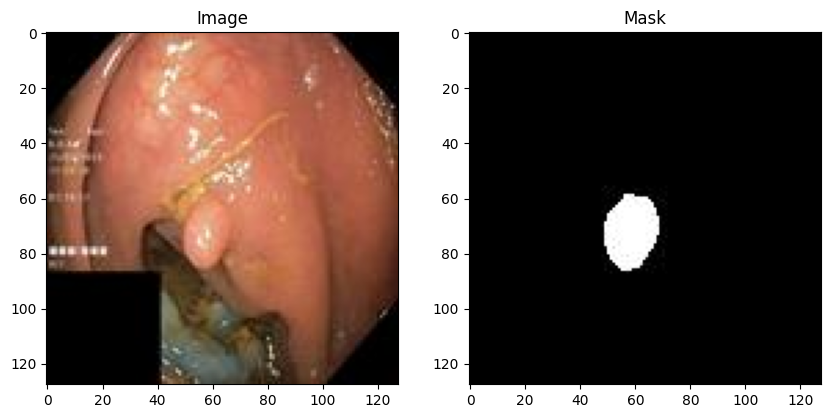

In [11]:
# plot the images and masks
def plot_images_and_masks(images, masks):
    num_images = len(images)
    fig, axs = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))
    for i in range(num_images):
        axs[0].imshow(images[i])
        axs[0].set_title("Image")
        axs[1].imshow(masks[i], cmap='gray')
        axs[1].set_title("Mask")
    plt.show()
# Get a batch of images and masks
for images, masks in train_loader:
    plot_images_and_masks(images, masks)
    break

In [12]:
# build the sam2 model
sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

In [13]:
# test the sam2 model with the first image from the train dataset
for i, (images, target_masks) in enumerate(train_loader):
    images = np.array(images)
    target_masks = np.array(target_masks)
    target_masks_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
    target_masks_sam_fixed[0] = cv2.resize(target_masks[0], (256, 256), interpolation=cv2.INTER_LINEAR)

    predictor.set_image(images[0])
    masks, _, _ = predictor.predict(mask_input=target_masks_sam_fixed)
    break

In [14]:
print(masks.shape)

(3, 128, 128)


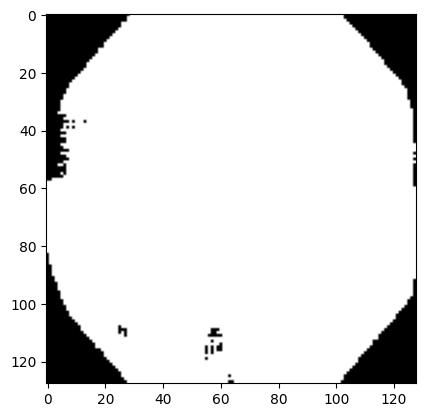

In [15]:
plt.imshow(masks[0], cmap='gray')

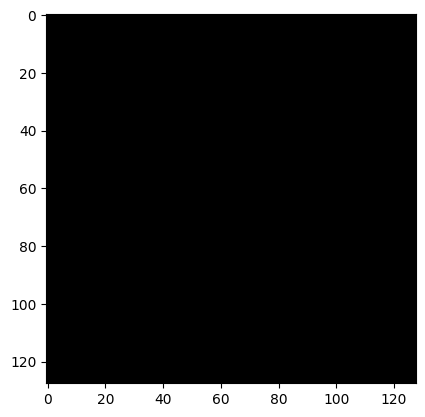

In [16]:
plt.imshow(masks[1], cmap='gray')

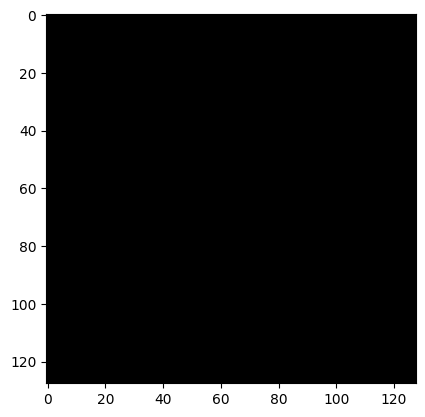

In [17]:
plt.imshow(masks[2], cmap='gray')

In [18]:
target_masks = np.array(target_masks)
target_masks.shape

(1, 128, 128)

In [19]:
target_masks[0].shape

(128, 128)

In [20]:
target_masks[0].max(), target_masks[0].min()

(1.0, 0.0)

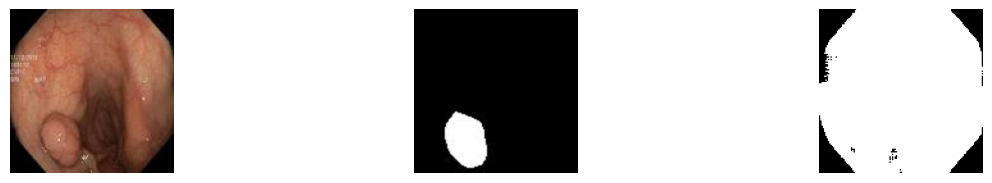

In [21]:
# visualize original images, prompt points, target masks and predicted masks
plt.figure(figsize=(20, 20))
for i in range(1):
    plt.subplot(8, 4, 4 * i + 1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.subplot(8, 4, 4 * i + 2)
    plt.imshow(target_masks_sam_fixed[i], cmap="gray")
    plt.axis("off")
    plt.subplot(8, 4, 4 * i + 3)
    plt.imshow(masks[0], cmap="gray")
    plt.axis("off")
plt.show()

In [22]:
target_masks.shape

(1, 128, 128)

In [23]:
target_masks[0].max(), target_masks[0].min()

(1.0, 0.0)

In [24]:
np.sum(target_masks[0], axis=1).shape

(128,)

In [25]:
torch.cuda.empty_cache()

In [26]:
# test the model on the test dataset and calculate the mean iou
ious = torch.zeros(len(test_loader)).to(device)
masks_list = []
ious_list = []
images_list_mem = []
target_masks_list = []

for i, (images, target_masks) in enumerate(test_loader):
    if i < 36:
        images_list_mem.append(images)
    target_masks = np.array(target_masks)
    images = np.array(images)

    predictor.set_image(images[0])
    target_masks_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
    target_masks_sam_fixed[0] = cv2.resize(target_masks[0], (256, 256), interpolation=cv2.INTER_LINEAR)
    masks, _, _ = predictor.predict(mask_input=target_masks_sam_fixed)
    if i < 36:
        masks_list.append(masks[0])
        target_masks_list.append(target_masks_sam_fixed)

    # 1. Compute Intersection over Union
    intersection = np.minimum(masks[0], target_masks).sum()
    union = np.maximum(masks[0], target_masks).sum()
    iou = intersection / union
    
    ious_list.append(iou)

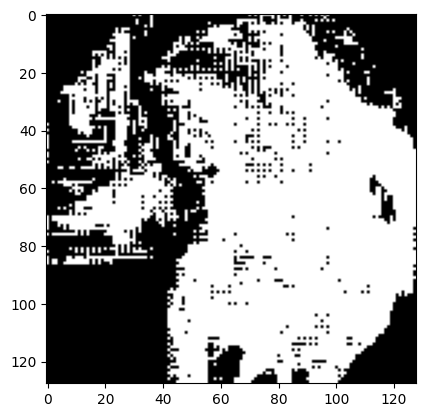

In [27]:
plt.imshow(masks_list[0], cmap="gray")

In [28]:
# calculate the mean iou and the std of the ious
ious = torch.tensor(ious_list)
ious.mean(), ious.std(), ious.max(), ious.min(), ious.median()

(tensor(0.0952, dtype=torch.float64),
 tensor(0.1124, dtype=torch.float64),
 tensor(0.6437, dtype=torch.float64),
 tensor(0., dtype=torch.float64),
 tensor(0.0591, dtype=torch.float64))

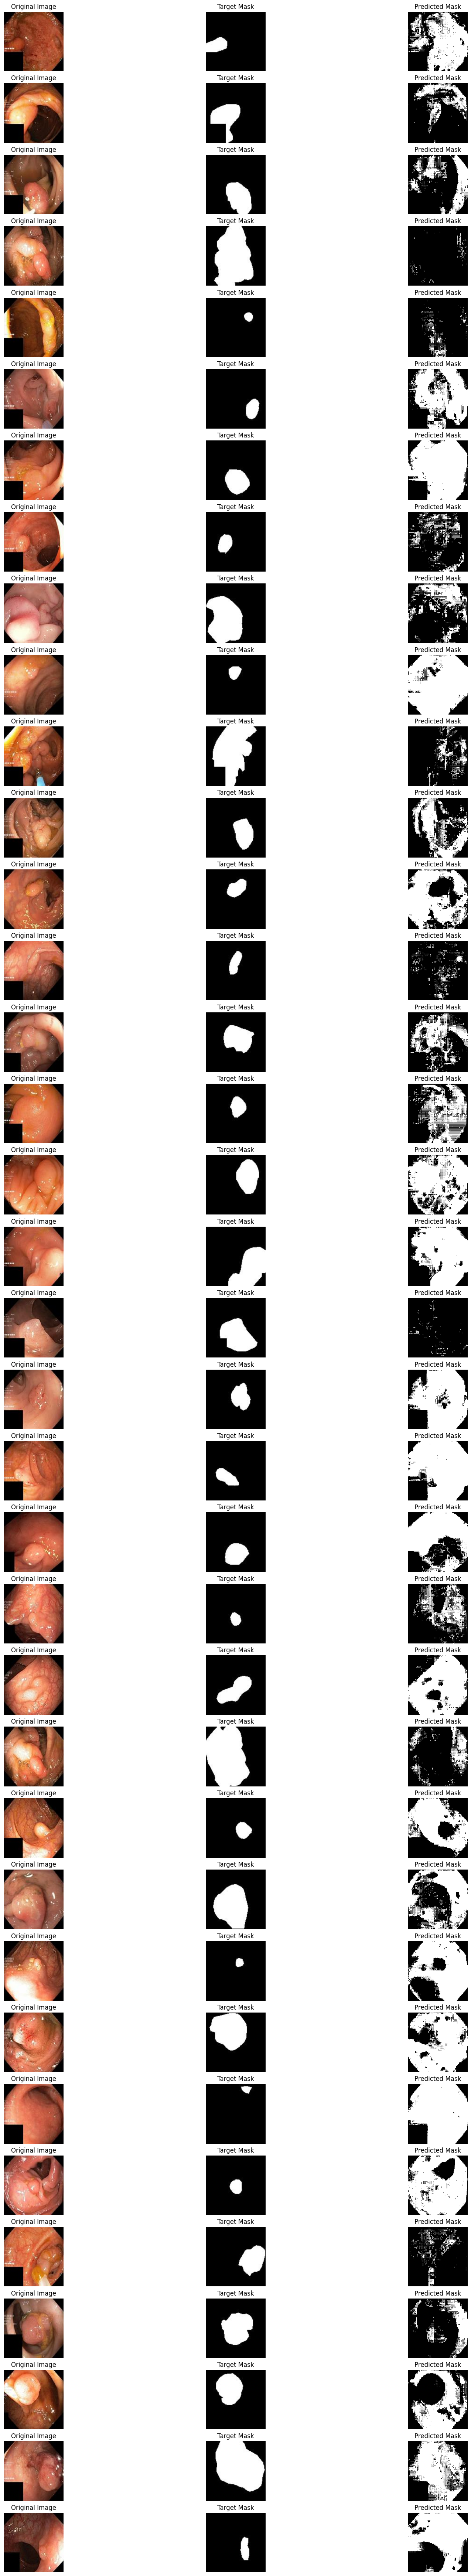

In [29]:
#visualize original images, prompt points, target masks and predicted masks of the test images
plt.figure(figsize=(20, 90))
# add title to the plot
for i in range(36):
    plt.subplot(36, 3, 3 * i + 1)
    plt.imshow(images_list_mem[i].squeeze(0))
    plt.title(f"Original Image")
    plt.axis("off")
    plt.subplot(36, 3, 3 * i + 2)
    plt.imshow(target_masks_list[i][0], cmap="gray")
    plt.title("Target Mask")
    plt.axis("off")
    plt.subplot(36, 3, 3 * i + 3)
    plt.imshow(masks_list[i], cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")
plt.show()